In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np


df = pd.read_csv('./data/df.csv',sep=',')
df  = df.sort_values(by='time',ascending=True).reset_index(drop=True)

BATCHSIZE = 256
LOOKBACK = 10


date = ["2024-02-19",
"2024-03-15",
"2024-04-19",
"2024-05-17",
"2024-06-21",
"2024-07-19",
"2024-08-16",
"2024-09-20",
"2024-10-18",
"2024-11-15",
"2024-12-20",
"2025-01-17"]
df.head()

df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date
df['date'] = df['date'].astype(str)
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute 
# for i in range(1,5):
#     df[f'spread_shift_{i}'] = df.groupby(['hour','minute'])['spread'].shift(i)

df['Expiration_Date'] = df['date'].apply(lambda x: 1 if x in date else 0)
# df.fillna(0,inplace=True)


df.dropna(inplace=True)

df.head()


,time,IF00_close,IF01_close,spread,date,hour,minute,Expiration_Date
0,2024-01-24 09:30:00,3240.0,3236.8,-3.2,2024-01-24,9,30,0
1,2024-01-24 09:31:00,3241.4,3243.0,1.6,2024-01-24,9,31,0
2,2024-01-24 09:32:00,3240.0,3243.0,3.0,2024-01-24,9,32,0
3,2024-01-24 09:33:00,3234.4,3235.6,1.2,2024-01-24,9,33,0
4,2024-01-24 09:34:00,3235.8,3236.0,0.2,2024-01-24,9,34,0


In [2]:
# train-test split for time series



import torch

def create_dataset(dataset, lookback,split_index):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """


    X_train, y_train = [], []
    X_test, y_test = [], []
    for i in range(len(dataset)-lookback):
        if i < split_index:
            feature = dataset[i:i+lookback]
            target = dataset[i+lookback:i+lookback+1][:,0:1]
            X_train.append(feature)
            y_train.append(target)
        else:
            feature = dataset[i:i+lookback]
            target = dataset[i+lookback:i+lookback+1][:,0:1]
            X_test.append(feature)
            y_test.append(target)
    # X = np.array(X)
    # y = np.array(y)
    return torch.tensor(X_train), torch.tensor(y_train),torch.tensor(X_test), torch.tensor(y_test)





In [3]:

# 设置随机种子以确保结果可复现
torch.manual_seed(42)

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 定义全连接神经网络模型
# class FCNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(FCNN, self).__init__()
#         self.cnn1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, output_size)
        
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.fc3(x)
#         return x

class CNN1D(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_size):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)  # Global average pooling
        self.fc = nn.Linear(hidden_channels, output_size)
        
    def forward(self, x):
        # x shape: (batch_size, input_channels, sequence_length)
        # print(x.shape)
        x = self.conv1(x)
        
        x = self.relu(x)
        # x = self.conv2(x)
        # x = self.relu(x)
        x = self.pool(x)  # Global average pooling
        x = x.squeeze(-1)  # Remove the last dimension
        x = self.fc(x)
        
        return x

# 定义早停类（从context中借鉴）
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        
    def __call__(self, val_loss, model, optimizer, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, optimizer, epoch)
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, optimizer, epoch)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model, optimizer, epoch):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'fcnn_checkpoint.pt')
        self.val_loss_min = val_loss


Using device: cuda


In [4]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import time 
begin_time = time.time()
df_result = pd.DataFrame()

timeseries = df['spread'].astype(np.float32).values.reshape(-1,1) 

for split_index in range(49837, len(timeseries),100):
    train_size = split_index # 
    # test_size = len(timeseries) - train_size
    # train, test = timeseries[:train_size], timeseries[train_size:]
    lookback = LOOKBACK 
    X_train_all, y_train_all,X_test, y_test = create_dataset(timeseries, lookback=lookback,split_index=split_index)
    # X_test, y_test = create_dataset(test, lookback=lookback)
    X_train_all = X_train_all.permute(0,2,1)
    X_test = X_test.permute(0,2,1)
    print(X_train_all.shape, y_train_all.shape)
    print(X_test.shape, y_test.shape)

    indices = np.arange(len(X_train_all))   
    np.random.shuffle(indices)
    train_val_size = int(len(X_train_all) * 0.8)
    train_indices = indices[:train_val_size]
    val_indices = indices[train_val_size:]
    X_train = X_train_all[train_indices]
    y_train = y_train_all[train_indices]
    X_val = X_train_all[val_indices]
    y_val = y_train_all[val_indices]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    X_train = X_train.to(device).squeeze(-1)
    y_train = y_train.to(device).squeeze(-1)
    X_val = X_val.to(device).squeeze(-1)
    y_val = y_val.to(device).squeeze(-1)
    X_test = X_test.to(device).squeeze(-1)
    y_test = y_test.to(device).squeeze(-1)

    model = CNN1D(1,20,1).to(device)
    model 


    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=BATCHSIZE)
    early_stopping = EarlyStopping(patience=10, min_delta=0.001)
    n_epochs = 1000
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            # X_batch = X_batch.squeeze(-1)
            # y_batch = y_batch.squeeze(-1)
            # print(X_batch.shape,y_batch.shape)
            # X_batch = X_batch.to(device)
            # y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            y_pred_val = model(X_val)
            # print(y_pred.shape,y_batch.shape)
            loss_train = loss_fn(y_pred, y_batch)
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        # Validation
        loss_val = loss_fn(y_pred_val, y_val)
        early_stopping(loss_val, model, optimizer, epoch)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.eval()
    with torch.no_grad():
        # X_train = X_train.to(device)
        # y_train = y_train.to(device)
        y_pred_train = model(X_train)
        # X_test = X_test.to(device)
        # y_test = y_test.to(device)
        train_rmse = torch.sqrt(loss_fn(y_pred_train, y_train))
        y_pred_test = model(X_test)
        test_rmse = torch.sqrt(loss_fn(y_pred_test, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    end_time = time.time()
    print(f"训练时间: {end_time - begin_time} 秒")

    predict_value = model(X_test)
    predict_value = predict_value.detach().cpu().numpy().flatten()


    df_result_tmp = pd.DataFrame([[split_index, predict_value[0],y_test[0].flatten().cpu().numpy()[0]]],columns=['split_index','predict','true'])
    df_result_tmp
    # df_result = pd.concat([df_result,df_result_tmp],ignore_index=True)
    df_result_tmp.to_csv('./data/cnn_result.csv',index=False,mode='a')
    
    del model
    del optimizer
    del loader
    del early_stopping
    del X_train
    del y_train
    del X_train_all
    del y_train_all
    del X_val
    del y_val
    del X_test
    del y_test
    del y_pred_train
    del y_pred_test
    del y_pred_val
    del y_pred
    del y_batch
    del X_batch
    torch.cuda.empty_cache()
    

C:\Users\gaoxc\AppData\Local\Temp\ipykernel_29528\3913454685.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(X_train), torch.tensor(y_train),torch.tensor(X_test), torch.tensor(y_test)


torch.Size([49837, 1, 10]) torch.Size([49837, 1, 1])
torch.Size([8716, 1, 10]) torch.Size([8716, 1, 1])


c:\Users\gaoxc\.conda\envs\chatglm3-demo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Early stopping
Epoch 236: train RMSE 1.1961, test RMSE 1.1460
训练时间: 141.38358402252197 秒
torch.Size([49937, 1, 10]) torch.Size([49937, 1, 1])
torch.Size([8616, 1, 10]) torch.Size([8616, 1, 1])
Early stopping
Epoch 230: train RMSE 1.1817, test RMSE 1.1500
训练时间: 270.71679186820984 秒
torch.Size([50037, 1, 10]) torch.Size([50037, 1, 1])
torch.Size([8516, 1, 10]) torch.Size([8516, 1, 1])
Early stopping
Epoch 183: train RMSE 1.2159, test RMSE 1.1471
训练时间: 375.7689127922058 秒
torch.Size([50137, 1, 10]) torch.Size([50137, 1, 1])
torch.Size([8416, 1, 10]) torch.Size([8416, 1, 1])
Early stopping
Epoch 15: train RMSE 1.4290, test RMSE 1.1544
训练时间: 385.364648103714 秒
torch.Size([50237, 1, 10]) torch.Size([50237, 1, 1])
torch.Size([8316, 1, 10]) torch.Size([8316, 1, 1])
Early stopping
Epoch 180: train RMSE 1.1572, test RMSE 1.1697
训练时间: 488.489634513855 秒
torch.Size([50337, 1, 10]) torch.Size([50337, 1, 1])
torch.Size([8216, 1, 10]) torch.Size([8216, 1, 1])
Early stopping
Epoch 166: train RMSE 1.17

In [5]:
X_batch.unsqueeze(1).shape 

NameError: name 'X_batch' is not defined

In [22]:
X_train_all.shape 

torch.Size([39237, 10, 1])

In [23]:
X_train_all.permute(0,2,1).shape 

torch.Size([39237, 1, 10])

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 设置SCI论文格式参数
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'lines.linewidth': 1.2,
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'grid.linestyle': '--',
    'grid.alpha': 0.6
})

# 创建数据
x = np.linspace(0, 2*np.pi, 100)

df_lstm_trendaware = pd.read_csv('./result/df_trendawarelstm_到期日前两天.csv',sep='\t')
df_lstm_trendaware
x = list(df_lstm_trendaware.index )
x 

df_fcnn = pd.read_csv('./result/df_fcnn_到期日前两天.csv',sep='\t')
df_fcnn

df_predict_gmgarch = pd.read_csv('./result/df_predict_gmgarch.csv_到期日前两天.csv',sep='\t')
df_predict_gmgarch

,Unnamed: 0,h.1,h.2,h.3,h.4,h.5,t.1,t.2,t.3,t.4,t.5,split_index,time
0,9922,-2.787922,-2.787922,-2.787922,-2.787922,-2.787922,-3.0,-3.2,-4.4,-3.6,-3.2,56734,2025-01-15 13:18:00
1,9923,-2.787625,-2.787625,-2.787625,-2.787625,-2.787625,-3.2,-4.4,-3.6,-3.2,-3.4,56735,2025-01-15 13:19:00
2,9924,-2.788970,-2.788970,-2.788970,-2.788970,-2.788970,-4.4,-3.6,-3.2,-3.4,-2.8,56736,2025-01-15 13:20:00
3,9925,-2.788282,-2.788282,-2.788282,-2.788282,-2.788282,-3.6,-3.2,-3.4,-2.8,-3.4,56737,2025-01-15 13:21:00
4,9926,-2.787972,-2.787972,-2.787972,-2.787972,-2.787972,-3.2,-3.4,-2.8,-3.4,-3.4,56738,2025-01-15 13:22:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,10400,-2.575522,-2.575522,-2.575522,-2.575522,-2.575522,0.2,1.0,1.0,0.6,3.6,57212,2025-01-17 13:14:00
479,10401,-2.568248,-2.568248,-2.568248,-2.568248,-2.568248,1.0,1.0,0.6,3.6,1.2,57213,2025-01-17 13:15:00
480,10402,-2.618775,-2.618775,-2.618775,-2.618775,-2.618775,1.0,0.6,3.6,1.2,1.8,57214,2025-01-17 13:16:00
481,10403,-2.628387,-2.628387,-2.628387,-2.628387,-2.628387,0.6,3.6,1.2,1.8,3.2,57215,2025-01-17 13:17:00


In [30]:
df_lstm = pd.read_csv('./result/df_predict_armean_1_2.csv_到期日前两天.csv',sep='\t')
df_cnn = pd.read_csv('./result/df_predict_armean_1_3.csv_到期日前两天.csv',sep='\t')


In [34]:
df_gjrgarch = pd.read_csv('./result/df_predict_gjrgarch.csv_到期日前两天.csv',sep='\t')
df_gjrgarch


df_armean = pd.read_csv('./result/df_predict_armean.csv_到期日前两天.csv',sep='\t')
df_armean


df_cnn_lstm = pd.read_csv('./result/df_predict_armean_2_2.csv_到期日前两天.csv',sep='\t')
df_lstm_fcnn = pd.read_csv('./result/df_predict_armean_2_3.csv_到期日前两天.csv',sep='\t')


0 Axes(0.125,0.559167;0.336957x0.320833)
1 Axes(0.563043,0.559167;0.336957x0.320833)
2 Axes(0.125,0.11;0.336957x0.320833)
3 Axes(0.563043,0.11;0.336957x0.320833)


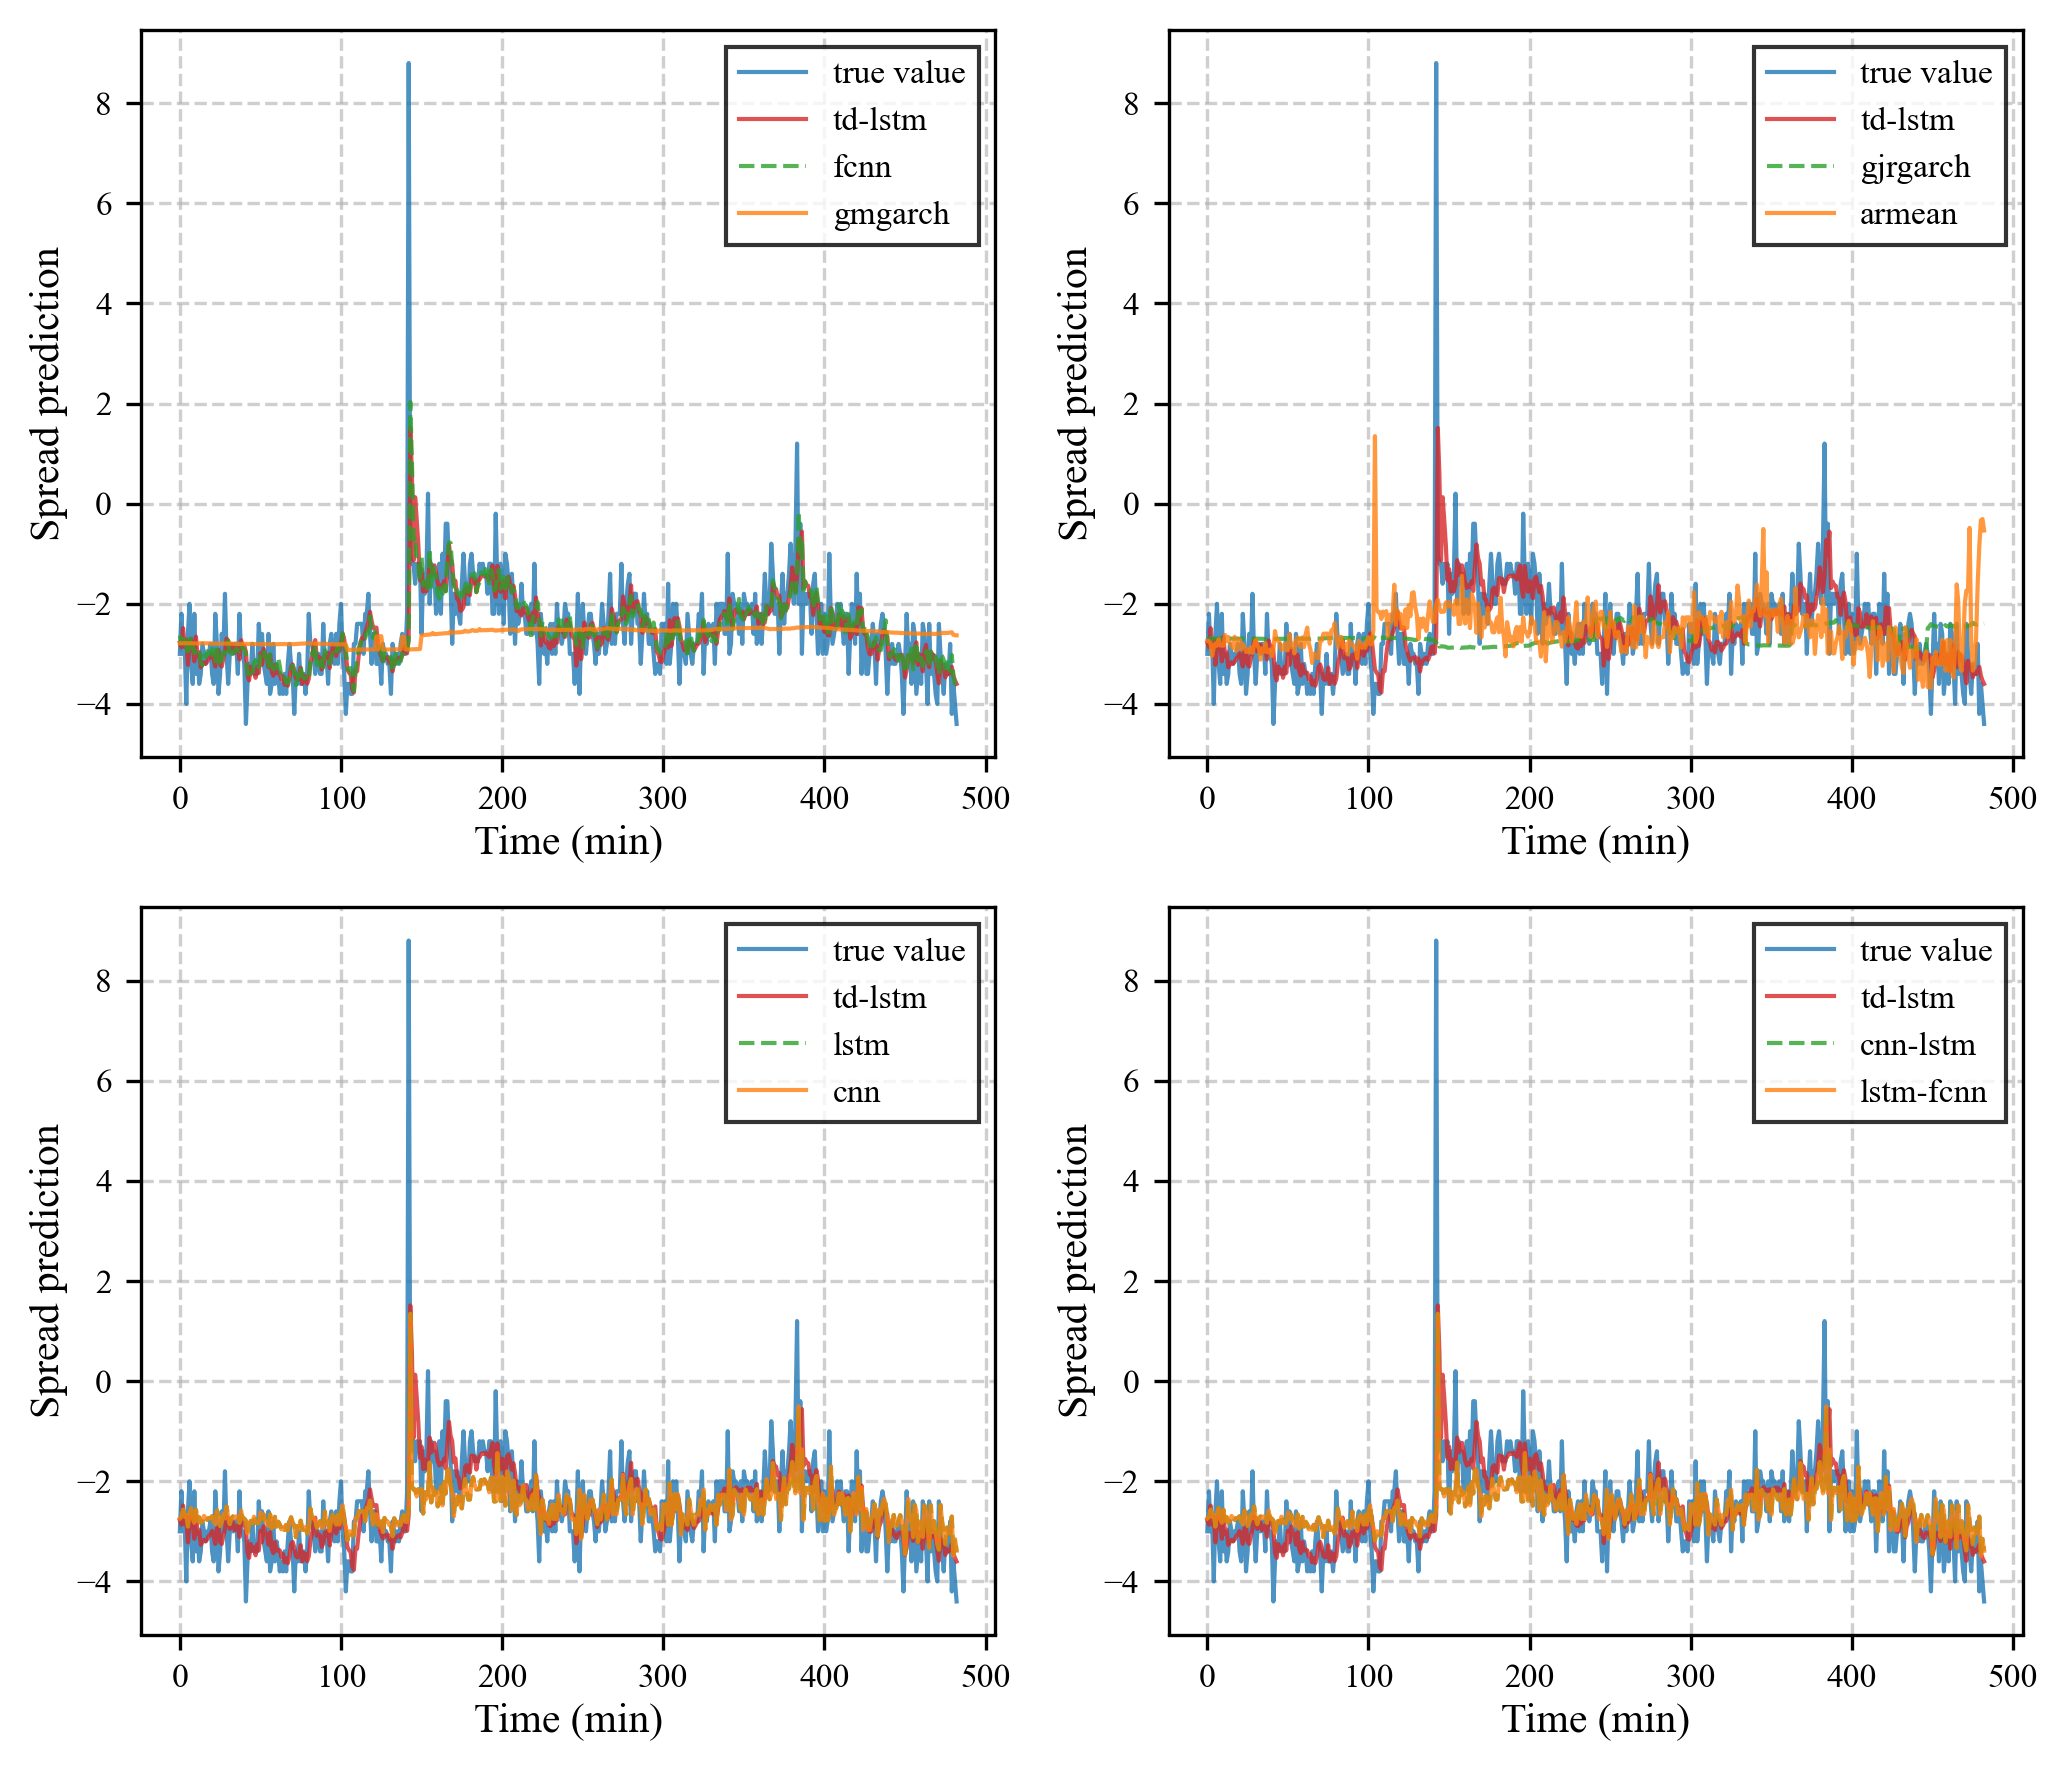

In [46]:

common_line = np.sin(x)  # 共同线
common_line_true,common_line_predict = df_lstm_trendaware['true'].values,df_lstm_trendaware['predict'].values
variations = [
    [df_fcnn['predict'].values,df_predict_gmgarch['h.1'].values],    # 子图1
    [df_gjrgarch['h.1'].values,df_armean['h.1'].values ],           # 子图2
   [df_lstm['h.1'].values,df_cnn['h.1'].values],              # 子图3
    [df_cnn_lstm['h.1'].values,df_lstm_fcnn['h.1'].values]      # 子图4
]
model_name = [['fcnn','gmgarch'],['gjrgarch','armean'],['lstm','cnn'],['cnn-lstm','lstm-fcnn']]
# 创建子图和画布
fig, axs = plt.subplots(2, 2, figsize=(7, 6), dpi=300)
plt.subplots_adjust(wspace=0.3, hspace=0.4)  # 调整子图间距

# 定义颜色和线型
#colors = ['#2CA02C', '#1F77B4', '#D62728']  # 使用SCI论文常用颜色
colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e']

linestyles = ['-', '--', '-']

# 绘制子图
for idx, ax in enumerate(axs.flat):
    # 绘制三条折线
    print(idx,ax) 
    ax.plot(x, common_line_true, color=colors[0], linestyle=linestyles[0],linewidth=1.0, alpha=0.8, label='true value')
    ax.plot(x, common_line_predict, color=colors[1], linestyle=linestyles[0],linewidth=1.0, alpha=0.8, label='td-lstm')
    ax.plot(x, variations[idx][0], color=colors[2], linestyle=linestyles[1],linewidth=1.0, alpha=0.8, label=model_name[idx][0])
    ax.plot(x, variations[idx][1], color=colors[3], linestyle=linestyles[2],linewidth=1.0, alpha=0.8, label=model_name[idx][1])
    
    # 添加标签和标题
    ax.set_xlabel('Time (min)', labelpad=2)
    ax.set_ylabel('Spread prediction', labelpad=2)
  
    
    # 设置坐标范围
    # ax.set_xlim(0, 2*np.pi)
    # ax.set_ylim(-1.5, 1.5)
    
    # 添加网格
    ax.grid(True)
    
    # 添加图例（仅第一个子图）
    # if idx == 0:
    ax.legend(loc='upper right', frameon=True, fancybox=False, 
                edgecolor='black', framealpha=0.8)

# 调整布局并保存
plt.tight_layout()
plt.savefig('sci_subplot.png', bbox_inches='tight', dpi=300)
plt.show()

In [5]:
from metrics import *
import pandas as pd 
metric = Metrics()
import os 
df_2 = pd.read_csv('./result/df_trendawarelstm_到期日前两天.csv',sep='\t')
df_2 
for root, dirs, files in os.walk('./data'):
    for file in files:
        if file.startswith('df_predict_armean_'):
            df = pd.read_csv(os.path.join(root, file),sep='\t')

            df['h.1'] = df['h.1'].astype(float)
            df['t.1'] = df['t.1'].astype(float)
            print(file, metric.MetricsAll(df[df['split_index'].isin(df_2['split_index'].values + 100)] ['t.1'],
                                        df[df['split_index'].isin(df_2['split_index'].values + 100)] ['h.1']))
            df[df['split_index'].isin(df_2['split_index'].values + 100)].to_csv(f'./result/{file}_到期日前两天.csv',sep='\t')

df_predict_armean_1_1.csv (0.5407675967978819, 0.8343140661339143, 0.21002794246813938, 0.19874431228639622, 4.401542896964619e-25)
df_predict_armean_1_2.csv (0.5407539564919102, 0.8342331177850418, 0.21002264472949, 0.1988997865402271, 4.10293867063694e-25)
df_predict_armean_1_3.csv (0.5406666074877191, 0.8341704548463085, 0.20998871937646307, 0.19902013037980792, 3.9879451220633676e-25)
df_predict_armean_2_1.csv (0.5407683570653219, 0.8343144364435884, 0.21002823774730756, 0.19874360101276334, 4.402291591513997e-25)
df_predict_armean_2_2.csv (0.540770507775846, 0.8342611353228045, 0.2100290730586481, 0.19884597608387722, 4.167568809282429e-25)
df_predict_armean_2_3.csv (0.5406909267675982, 0.8342205290266937, 0.20999816470629712, 0.19892396390910272, 4.1149379140262886e-25)
df_predict_armean_3_1.csv (0.5407806939017905, 0.8343578715593963, 0.2100330292333274, 0.198660170668304, 4.477361211952475e-25)
